[View in Colaboratory](https://colab.research.google.com/github/znah/notebooks/blob/master/geodesic.ipynb)

#Geodesic distance transform

This notebook shows how Geodesic Discance Transform (GDT) using Fast Sweeping Method (FSM) can be implemented using Python. GDT can be thought of as a computation of shortest pathes on an image plane with a given cost function. It can be used as a part of more complex image processing tasks such as segmentation or coloring [[1]](http://research.microsoft.com/apps/pubs/default.aspx?id=81528).

The description of different GDT construction methods can be found in [[2]](http://www.eng.biu.ac.il/~weberof/Publications/PMM/Parallel_Algorithms_for_Approximation_of_Distance_Maps_on_Parametric_Surfaces.pdf).

In [0]:
!pip install -q numba
!pip install -q moviepy

In [0]:
# some preparations first
import numpy as np
import scipy.ndimage as nd
import PIL.Image
import itertools as it
import matplotlib.pylab as pl
import moviepy.editor as mvp
from IPython.display import Image, display
from google.colab import files
import numba

We use image gradient magnitude to costruct our cost function.

In [0]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg -O img.jpg

In [0]:
img = PIL.Image.open('img.jpg').convert('L')
w = img.size[0]
img = img.crop([0, 0, w, w])
img = np.float32(img)/255.0

`sweep` function is the core of the algorithm. It propogates shortest path wavefront in right-down direction. We use Numba to accelerate pixel iteration.

In [0]:
@numba.jit
def sweep(A, Cost):
    max_diff = 0.0
    for i in range(1, A.shape[0]):
        for j in range(1, A.shape[1]):
            t1, t2 = A[i, j-1], A[i-1, j]
            C = Cost[i, j]
            if abs(t1-t2) > C:
                t0 = min(t1, t2) + C  # handle degenerate case
            else:    
                t0 = 0.5*(t1 + t2 + np.sqrt(2*C*C - (t1-t2)**2))
            max_diff = max(max_diff, A[i, j] - t0)
            A[i, j] = min(A[i, j], t0)
    return max_diff


`GDT` function uses NumPy array slicing to sweep the wavefront in four possible directions.

In [0]:
def GDT(A, C, max_iter_n=80, max_diff=0.1):
    A = A.copy()
    sweeps = [A, A[:,::-1], A[::-1], A[::-1,::-1]]
    costs = [C, C[:,::-1], C[::-1], C[::-1,::-1]]
    for i, (a, c) in enumerate(it.cycle(zip(sweeps, costs))):
        r = sweep(a, c)
        print(i, r)
        if r < max_diff or i >= max_iter_n:
            break
    return A

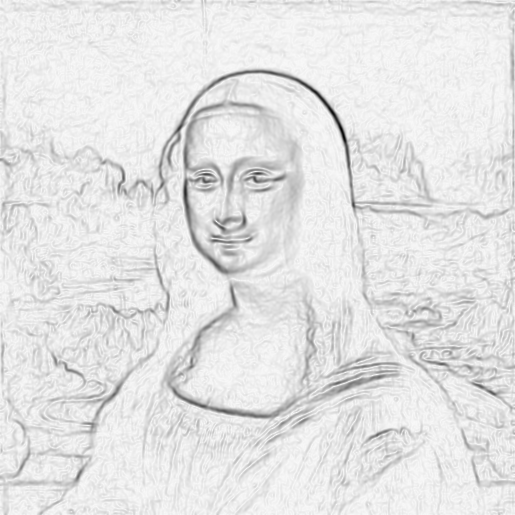

In [223]:
img1 = (img-img.min()) / img.ptp()
G = nd.gaussian_gradient_magnitude(img1, 1.5)
Cost = 1.0+G*200
vis = np.uint8(1.0-Cost/Cost.max()*255.0)
PIL.Image.fromarray(vis)

In [205]:
%%time
A = np.zeros_like(Cost) # create distance accumulation array
A[:] = 1e6           # fill it with large values to mark
                     # cells with unknown distance
A[190, 235] = 0      # set the source

A = GDT(A, Cost)

0 999995.9231472015
1 999995.5714535713
2 999996.0315690041
3 999303.5185361739
4 104.47993373545944
5 66.74547777685055
6 22.432663409338943
7 7.20054679418547
8 10.425076632478294
9 5.1789392719375655
10 4.866122233377496
11 3.2874965866358252
12 4.847050576588231
13 3.0597416055454687
14 3.1718473549769897
15 1.3190153392057482
16 1.7629972186615532
17 0.9448876647555835
18 1.2469714724352343
19 0.825530348479333
20 0.5988547857967887
21 0.4310386534668851
22 0.21094039180275104
23 0.22536042339811502
24 0.33716318595429584
25 0.1878662109375
26 0.08845558409643672
CPU times: user 166 ms, sys: 9.23 ms, total: 176 ms
Wall time: 173 ms


Here is the contour plot of the GDT with the given cost function. Note, how isolines tend to follow image edges.

In [221]:
duration = 0.5

def frame(t):
  fig = pl.figure(figsize=(8, 8))
  hi = A.max()
  n = 40
  trs = np.linspace(0, hi, n+1)
  t /= duration
  pl.contour(A, trs+t*hi/n, origin='image', colors='black')
  ax = pl.gca()
  ax.set_facecolor('white')
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  pl.tight_layout()
  pl.grid()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)[..., :3]
  pl.close()
  return img

#PIL.Image.fromarray(frame(0))
clip = mvp.VideoClip(frame, duration=duration)
clip.write_videofile('out.mp4', fps=30.0)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 94%|█████████▍| 15/16 [00:05<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [219]:
clip.write_gif('out.gif', fps=30, opt='wu')


[MoviePy] Building file out.gif with imageio


 94%|█████████▍| 15/16 [00:04<00:00,  3.12it/s]


In [222]:
mvp.ipython_display('out.mp4', loop=True)

In [0]:
files.download('out.gif')